# Performing Multi-Modal RAG

With the document image embeddings generated and stored in the collection, you're ready to begin performing RAG!

This will include embedding the text query using the same multi-modal ColPali model you used for the images. Then, you can query the collection and generate a response using similar syntax to the all-text case in Chapter 2.

**Run this install cell as soon as you begin, as it may take >1min to complete due to the size of the `colpali-engine` library.**

In [12]:
!pip install --quiet colpali-engine==0.3.12 weaviate-client==4.16.10 pydantic==2.11.9

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


**Run the hidden cell below to re-create your Weaviate collection and image embeddings.**

In [13]:
import os
import weaviate
from openai import OpenAI as OpenAIClient

raw_client = OpenAIClient()
API_KEY  = str(raw_client.api_key)
API_BASE = str(raw_client.base_url)

HEADERS = {
    "X-OpenAI-Api-Key": API_KEY,
    "X-OpenAI-BaseURL": API_BASE.rstrip("/").removesuffix("/v1"),
}

try:
    client = weaviate.connect_to_embedded(
        version="1.32.3",
        headers=HEADERS,
        environment_variables={"LOG_LEVEL": "error"},
    )
except weaviate.exceptions.WeaviateStartUpError:
    # If already running, connect to it instead
    client = weaviate.connect_to_local(
        port=8079,
        grpc_port=50050,
        headers=HEADERS,
    )

if "Pages" in client.collections.list_all():
    client.collections.delete("Pages")

from weaviate.classes.config import Property, DataType, Configure

client.collections.create(
    name="Pages",
    properties=[
        Property(
            name="document_title",
            data_type=DataType.TEXT,
        ),
        Property(
            name="page_image",
            data_type=DataType.BLOB,
        ),
        Property(
            name="filename",
            data_type=DataType.TEXT,
        ),
    ],
    vector_config=[
        Configure.MultiVectors.self_provided(name="default")
    ]
)

import numpy as np
import json
from tqdm import tqdm
from pathlib import Path
import base64
from weaviate.util import generate_uuid5

pages = client.collections.use("Pages")
with open("data/embeddings/embeddings_metadata.json", "r") as f:
    metadata = json.load(f)

embeddings = np.load("data/embeddings/image_embeddings.npy")

with pages.batch.fixed_size(batch_size=100) as batch:
    for i, embedding in tqdm(enumerate(embeddings)):
        filepath = Path(metadata["image_paths"][i])
        image = filepath.read_bytes()
        base64_image = base64.b64encode(image).decode('utf-8')
        obj = {
            "document_title": "Stanford AI Index Report 2025",
            "page_image": base64_image,
            "filename": filepath.name
        }
        
        batch.add_object(
            properties=obj,
            uuid=generate_uuid5(str(filepath)),
            vector={"default": embedding}
        )

{"action":"load_all_shards","build_git_commit":"","build_go_version":"go1.24.6","build_image_tag":"","build_wv_version":"1.32.3","level":"error","msg":"failed to load all shards: context canceled","time":"2025-11-07T10:52:47Z"}
8it [00:00, 33.36it/s]


### Queries

Let's try some queries. We'll use the same process as before to generate the query embedding. 

**Instantiate the `ColIdefics3` model and accompanying processor and embed the query provided (`query`).**

In [14]:
import os
import torch
from colpali_engine.models import ColIdefics3, ColIdefics3Processor

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

model = ColIdefics3.from_pretrained(
    "vidore/colSmol-256M",
    torch_dtype=torch.float32,  # use float32 for CPU
    device_map="cpu",           # explicitly use CPU
).eval()

In [15]:
processor = ColIdefics3Processor.from_pretrained(
    "vidore/colSmol-256M",
)

processor.image_processor.token_pooling = True
processor.image_processor.size = {"longest_edge": 224}

The query embedding can be generated similarly to before, but using the `.process_queries()` method this time instead of `.process_images()`.

In [16]:
query = "self-driving cars"
batch_queries = processor(text=[query], return_tensors="pt").to("cpu")

with torch.no_grad():
    query_embeddings = model(**batch_queries)
query_embedding = query_embeddings[0].to("cpu").tolist()

Since you have the embedded query (`query_embedding`), you can use the `.near_vector()` method to find the most relevant pages in the collection.

**Use `query_embedding` to query the `pages` collection using a vector search and return the top `3` page images.**

In [17]:
response = pages.query.near_vector(
    near_vector=query_embedding,
    limit=3,
)

for o in response.objects:
    print(f"Filename: {o.properties['filename']}")

Filename: hai_ai-index-report-2025_chapter2_excerpts_7_of_8.jpg
Filename: hai_ai-index-report-2025_chapter2_excerpts_8_of_8.jpg
Filename: hai_ai-index-report-2025_chapter2_excerpts_4_of_8.jpg


And we can see which pages come back as the most relevant to the query:

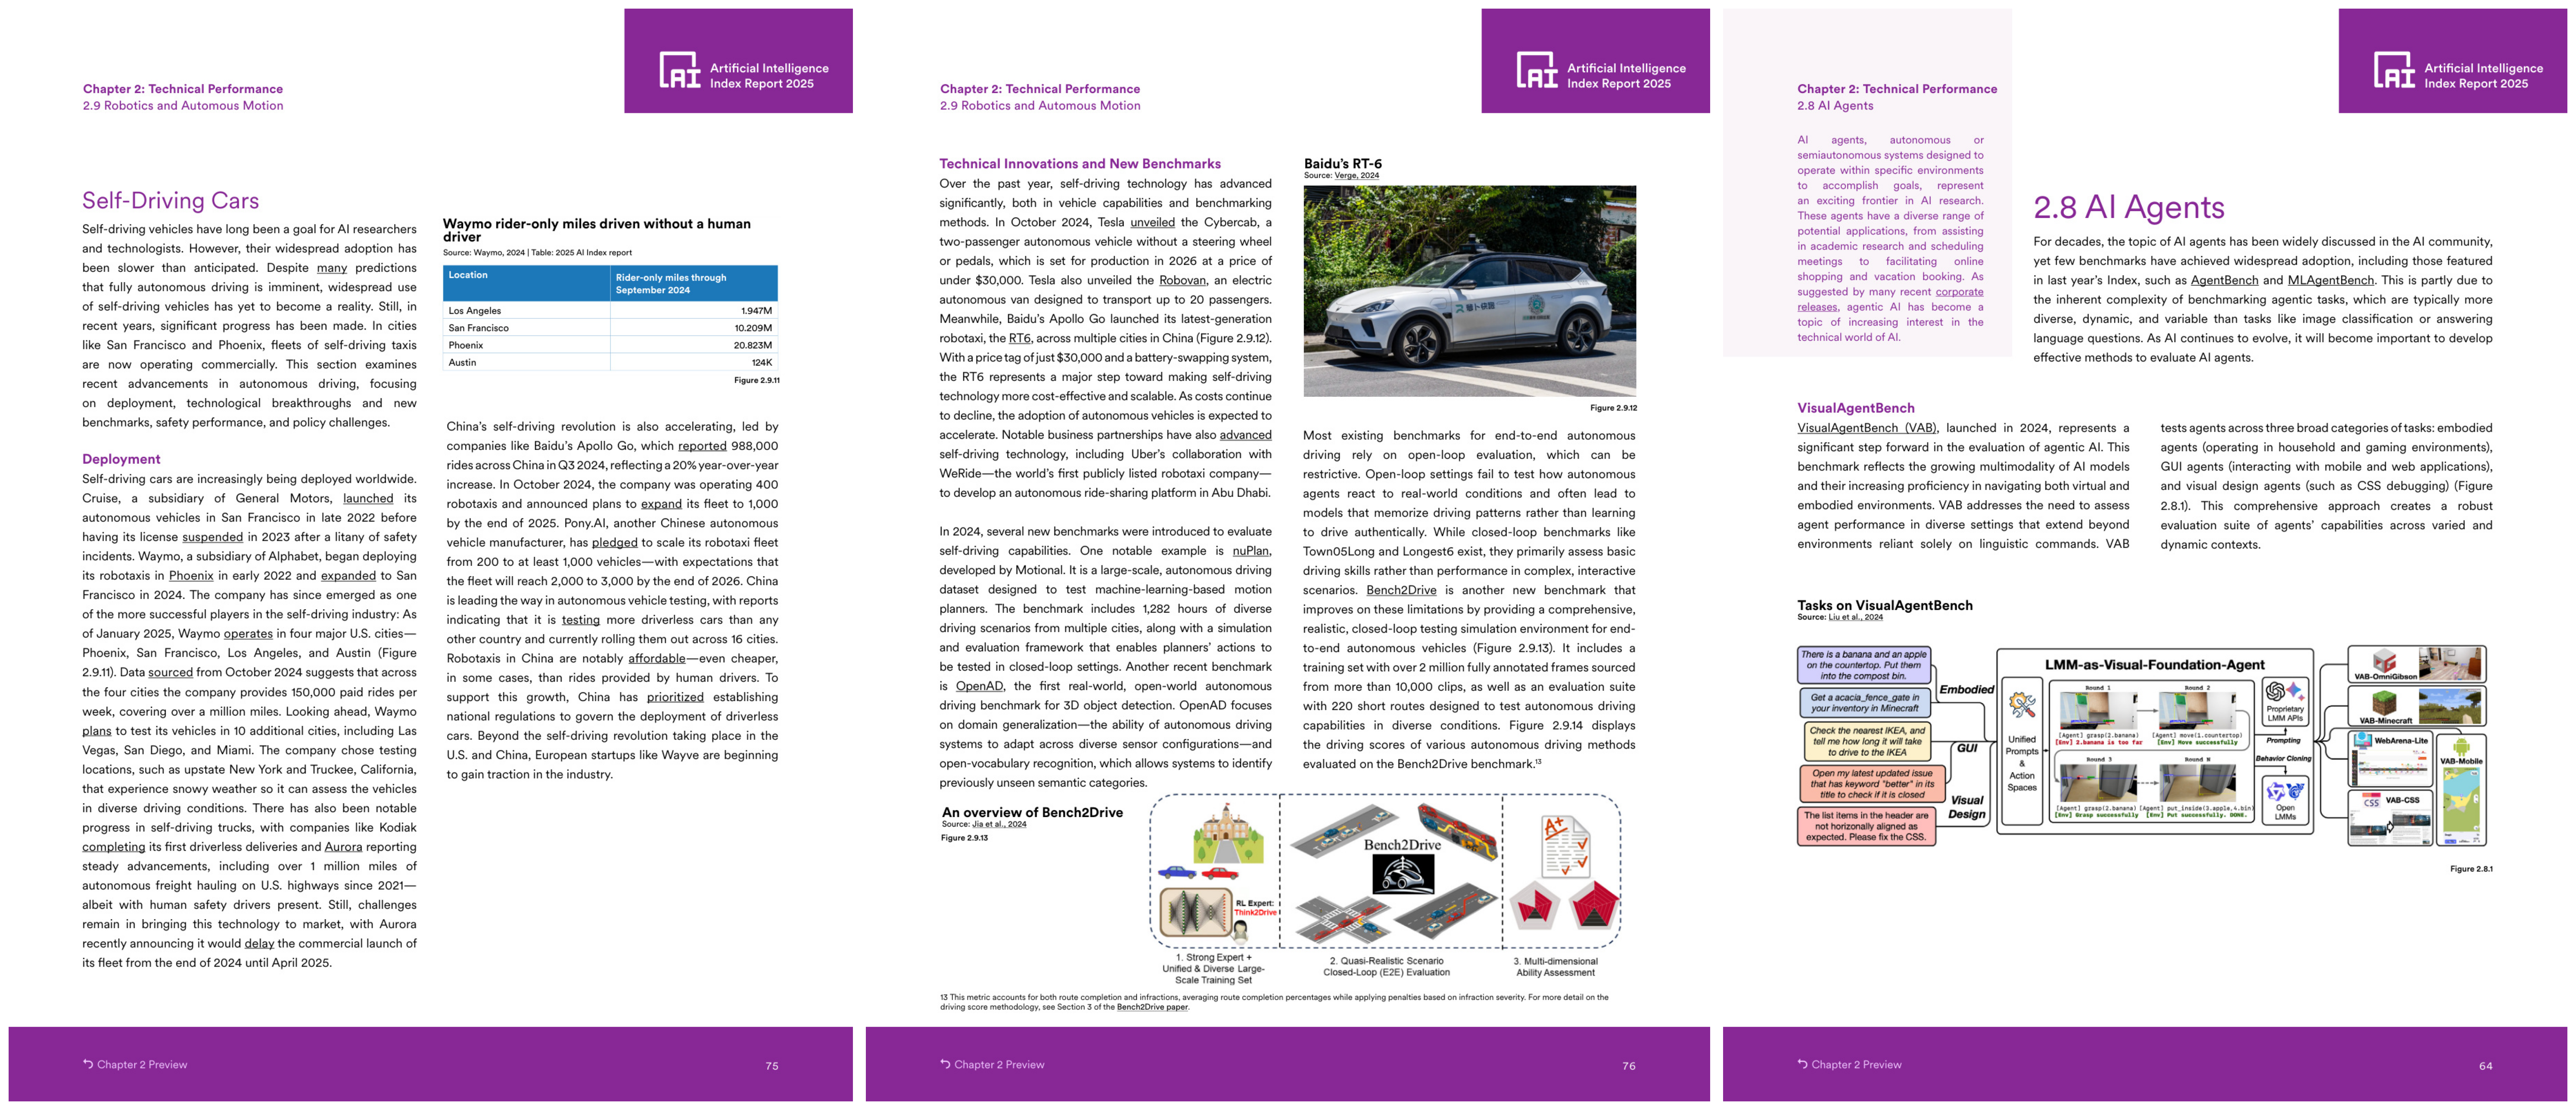

In [18]:
import matplotlib.pyplot as plt
from PIL import Image

images = [
    f"data/imgs/" + o.properties['filename'] for o in response.objects
]

fig, axes = plt.subplots(1, 3, figsize=(30, 15))

for i, img_path in enumerate(images):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Retrieval Augmented Generation (RAG)

Now that we've seen how to retrieve images of pages, let's take it a step further by performing RAG with the retrieved images.

![images/multimodal_rag.png](images/multimodal_rag.png)

The retrieved images and query can be combined in a multi-modal prompt to generate a response. Note we use are also using a multi-modal generative model here (`gpt-4o-mini`).

**Create a multi-modal prompt using the `"page_image"` image property, and use it along with `query_embedding` to query the `pages` collection.**

In [19]:
from weaviate.classes.generate import GenerativeConfig, GenerativeParameters

prompt = GenerativeParameters.grouped_task(
    prompt="What advances have there been in self-driving cars?",
    image_properties=["page_image"],  # Property containing images in Weaviate
)

# Generate a response based on the retrieved pages
response = pages.generate.near_vector(
    near_vector=query_embedding,
    limit=1,
    # These parameters are used to define the RAG task & model
    grouped_task=prompt,
    generative_provider=GenerativeConfig.openai(model="gpt-4o-mini",)
)

print(response.generative.text)

Recent advances in self-driving cars highlight significant progress in deployment and technology. Key points include:

1. **Increased Deployment**: Companies like Cruise (a GM subsidiary) and Waymo (an Alphabet subsidiary) have launched autonomous operations in major U.S. cities, including San Francisco and Phoenix. 

2. **Rider-Only Miles**: Waymo has reported substantial rider-only miles driven, with over 20 million in Phoenix alone, indicating growth in commercial viability.

3. **Global Expansion**: In China, companies like Baidu and Pony.AI are rapidly expanding their fleets and testing autonomous vehicles across multiple cities, with increasing ridership year-over-year.

4. **Technological Breakthroughs**: Developments have included advancements in safety performance and vehicle technology, with companies like Aurora and Kodiak making strides in autonomous trucking.

5. **Regulatory Support**: China is actively supporting the growth of autonomous vehicle technologies with regulat

We see from the output that the model has understood the contents of the image and responded to the query!

### Close the client

Remember to close the client library connection & Weaviate.

In [20]:
client.close()

{"build_git_commit":"","build_go_version":"go1.24.6","build_image_tag":"","build_wv_version":"1.32.3","error":"context canceled","level":"error","msg":"replication engine failed to start after FSM caught up","time":"2025-11-07T10:53:07Z"}
{"build_git_commit":"","build_go_version":"go1.24.6","build_image_tag":"","build_wv_version":"1.32.3","error":"cannot find peer","level":"error","msg":"transferring leadership","time":"2025-11-07T10:53:07Z"}
